# Queue Length Analysis

## Functionalities
- Plot number of connections to each server and thresholds for queueing and packet dropping (max. number of threads and TCP buffer size, respectively).
- Plot queue length of each server.

## Input
Log files are read from a directory in `../data`. This directory is assumed to have the following structure:
```
logs/
  [node-1]/
    *_service*.tar.gz
    ...
    apigateway*.tar.gz
  ...
  [node-n]/
    *_service*.tar.gz
    ...
    apigateway*.tar.gz
```
`*_service*.tar.gz` and `apigateway*.tar.gz` tarballs contain RPC log files named `calls.log` and database query log files named `queries.log`.

## Notebook Configuration

In [4]:
########## GENERAL
# Name of the directory in `../data`
EXPERIMENT_DIRNAME = "BuzzBlogBenchmark_2022-04-14-05-07-57"

########## CONNECTION
# Window size
WINDOW_IN_MS = 1

########## THRIFT SERVERS
THRIFT_SOMAXCONN = 1024
THRIFT_THREADS = 80

########## POSTGRES SERVERS
PG_SOMAXCONN = 1024
PG_MAX_CONNECTIONS = 128

## Notebook Setup

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import pandas as pd
import sys
import warnings
warnings.filterwarnings("ignore")

sys.path.append(os.path.abspath(os.path.join("..")))
from utils.utils import *

experiment_dirpath = os.path.join(os.path.abspath(""), "..", "data", EXPERIMENT_DIRNAME)

## RPC Log Parsing & Processing

In [6]:
# Build data frame
rpc = pd.concat([df[2] for df in get_rpc_df(experiment_dirpath)])

In [7]:
# Extract experiment information
start_time = get_experiment_start_time(experiment_dirpath)
servers = sorted(rpc["server"].unique())

In [8]:
# (Re) Build columns
rpc["timestamp"] = rpc.apply(lambda r: (r["timestamp"] - start_time).total_seconds(), axis=1)
rpc["window"] = rpc.apply(lambda r: range(int(r["timestamp"] * 1000) // WINDOW_IN_MS,
        int((r["timestamp"] + r["latency"]) * 1000) // WINDOW_IN_MS + 1), axis=1)
rpc = rpc.explode("window")

## Microservices Queue Length Analysis

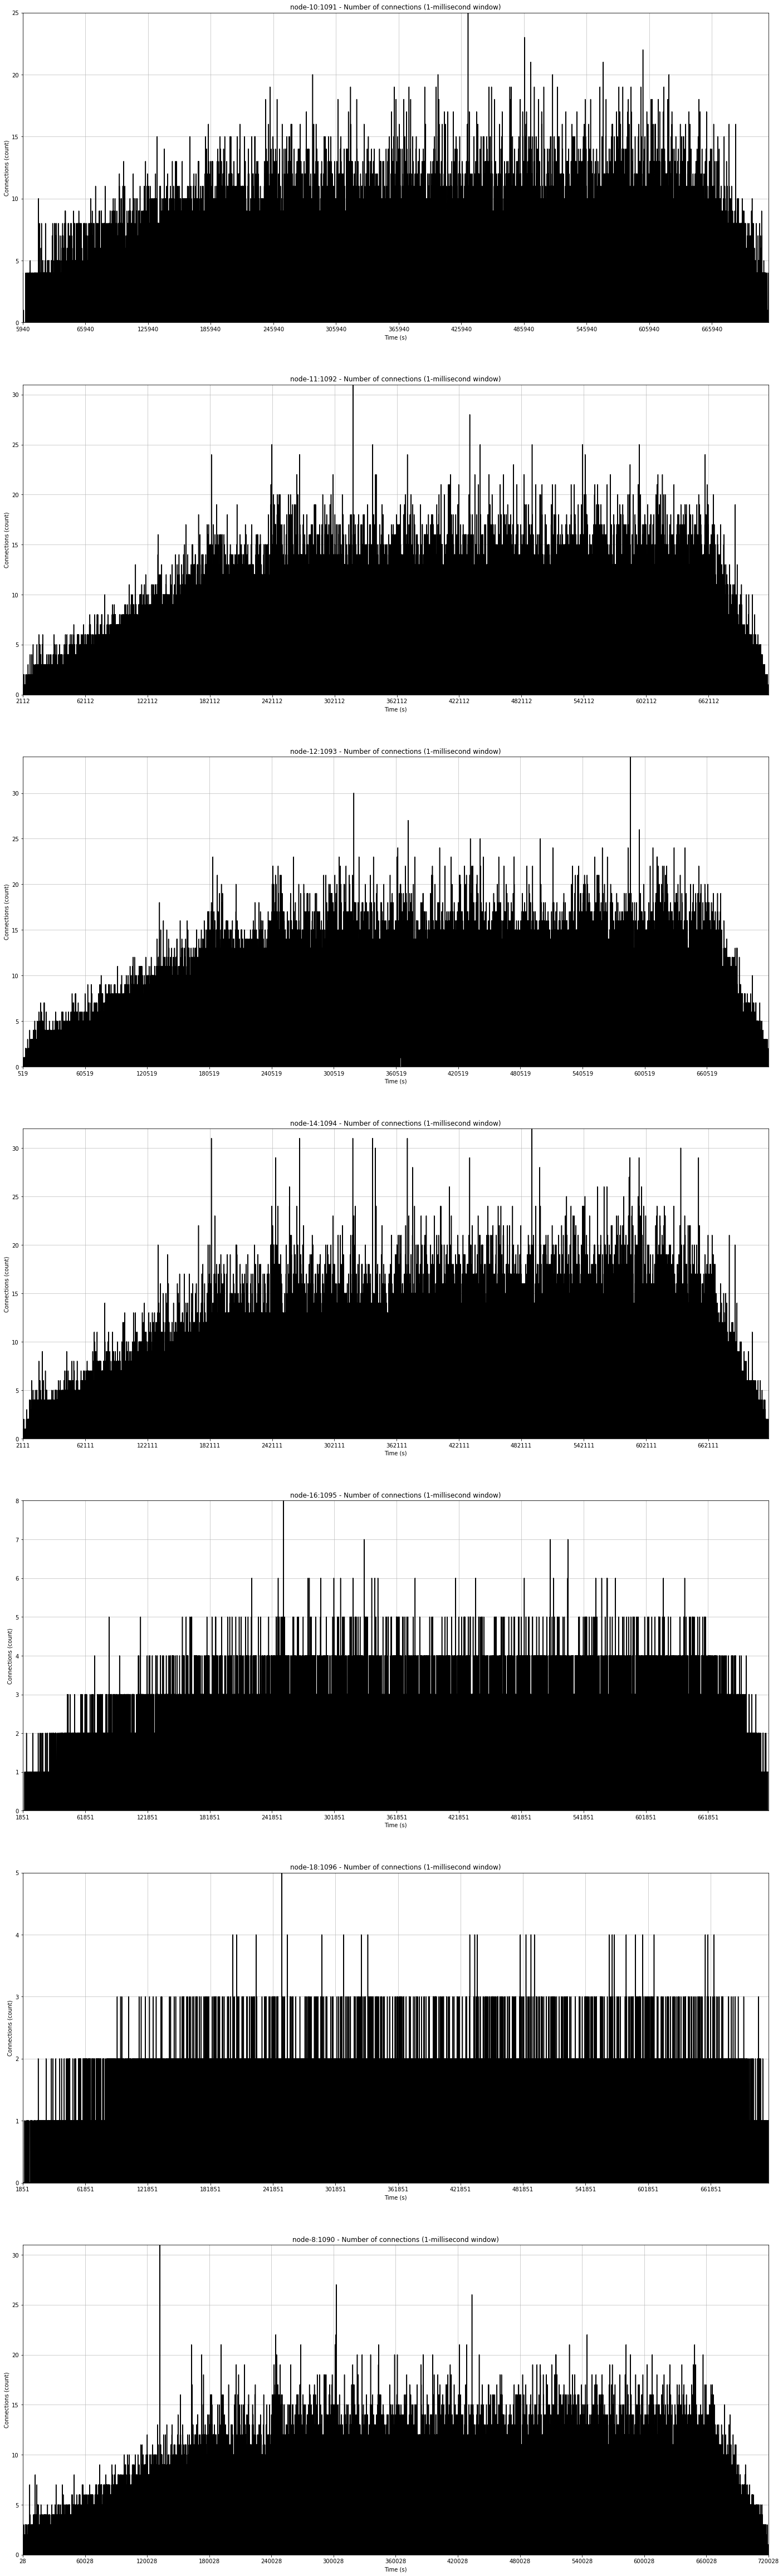

In [9]:
########## LOCAL CONFIG
# Minimum time (in seconds)
MIN_TIME = None
# Maximum time (in seconds)
MAX_TIME = None

# Plot number of connections
fig = plt.figure(figsize=(24, len(servers) * 12))
for (i, server) in enumerate(servers):
    df = rpc[(rpc["server"] == server)]
    if MIN_TIME:
        df = df[(df["timestamp"] >= MIN_TIME)]
    if MAX_TIME:
        df = df[(df["timestamp"] <= MAX_TIME)]
    df = df.groupby(["window"])["window"].count()
    df = df.reindex(range(int(df.index.min()), int(df.index.max()) + 1), fill_value=0)
    ax = fig.add_subplot(len(servers), 1, i + 1)
    ax.grid(alpha=0.75)
    ax.set_xlim((df.index.min(), df.index.max()))
    ax.set_ylim((0, df.values.max()))
    ax.axhline(y=THRIFT_THREADS, ls="--", color="blue", linewidth=5)
    ax.axhline(y=THRIFT_THREADS + THRIFT_SOMAXCONN, ls="--", color="red", linewidth=5)
    df.plot(ax=ax, kind="line",
        title="%s - Number of connections (%s-millisecond window)" % (server, WINDOW_IN_MS),
        xlabel="Time (s)", ylabel="Connections (count)", color="black", grid=True,
        xticks=range(int(df.index.min()), int(df.index.max()) + 1, 60 * (1000 // WINDOW_IN_MS)))

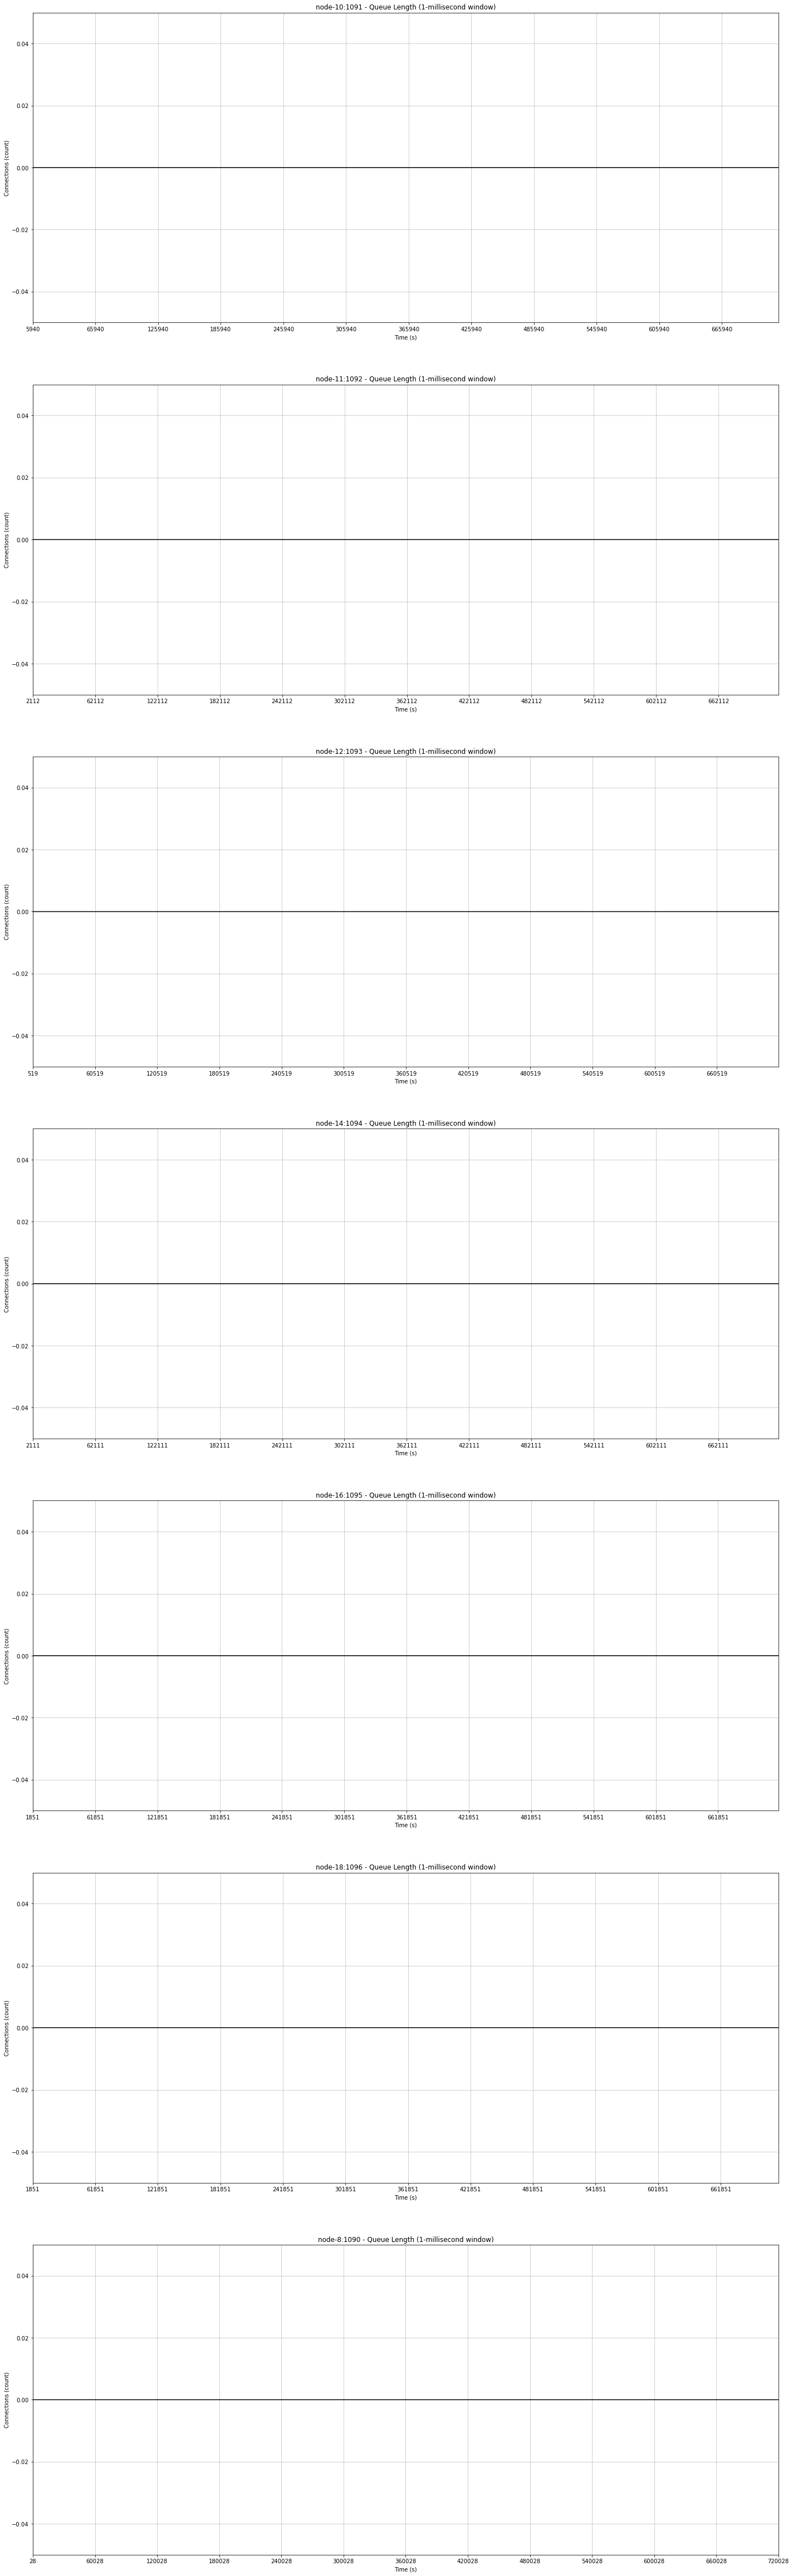

In [10]:
########## LOCAL CONFIG
# Minimum time (in seconds)
MIN_TIME = None
# Maximum time (in seconds)
MAX_TIME = None

# Plot queue length
fig = plt.figure(figsize=(24, len(servers) * 12))
for (i, server) in enumerate(servers):
    df = rpc[(rpc["server"] == server)]
    if MIN_TIME:
        df = df[(df["timestamp"] >= MIN_TIME)]
    if MAX_TIME:
        df = df[(df["timestamp"] <= MAX_TIME)]
    df = df.groupby(["window"])["window"].count()
    df = df.apply(lambda r: max(r - THRIFT_THREADS, 0))
    df = df.reindex(range(int(df.index.min()), int(df.index.max()) + 1), fill_value=0)
    ax = fig.add_subplot(len(servers), 1, i + 1)
    ax.grid(alpha=0.75)
    ax.set_xlim((df.index.min(), df.index.max()))
    ax.set_ylim((0, df.values.max()))
    ax.axhline(y=THRIFT_SOMAXCONN, ls="--", color="red", linewidth=5)
    df.plot(ax=ax, kind="line",
        title="%s - Queue Length (%s-millisecond window)" % (server, WINDOW_IN_MS),
        xlabel="Time (s)", ylabel="Connections (count)", color="black", grid=True,
        xticks=range(int(df.index.min()), int(df.index.max()) + 1, 60 * (1000 // WINDOW_IN_MS)))

## Query Log Parsing & Processing

In [11]:
# Build data frame
query = pd.concat([df[2] for df in get_query_df(experiment_dirpath)])

In [12]:
# Extract experiment information
start_time = get_experiment_start_time(experiment_dirpath)
dbnames = sorted(query["dbname"].unique())

In [13]:
# (Re) Build columns
query["timestamp"] = query.apply(lambda r: (r["timestamp"] - start_time).total_seconds(), axis=1)
query["window"] = query.apply(lambda r: range(int(r["timestamp"] * 1000) // WINDOW_IN_MS,
        int((r["timestamp"] + r["latency"] / 1000) * 1000) // WINDOW_IN_MS + 1), axis=1)
query = query.explode("window")

## Databases Queue Length Analysis

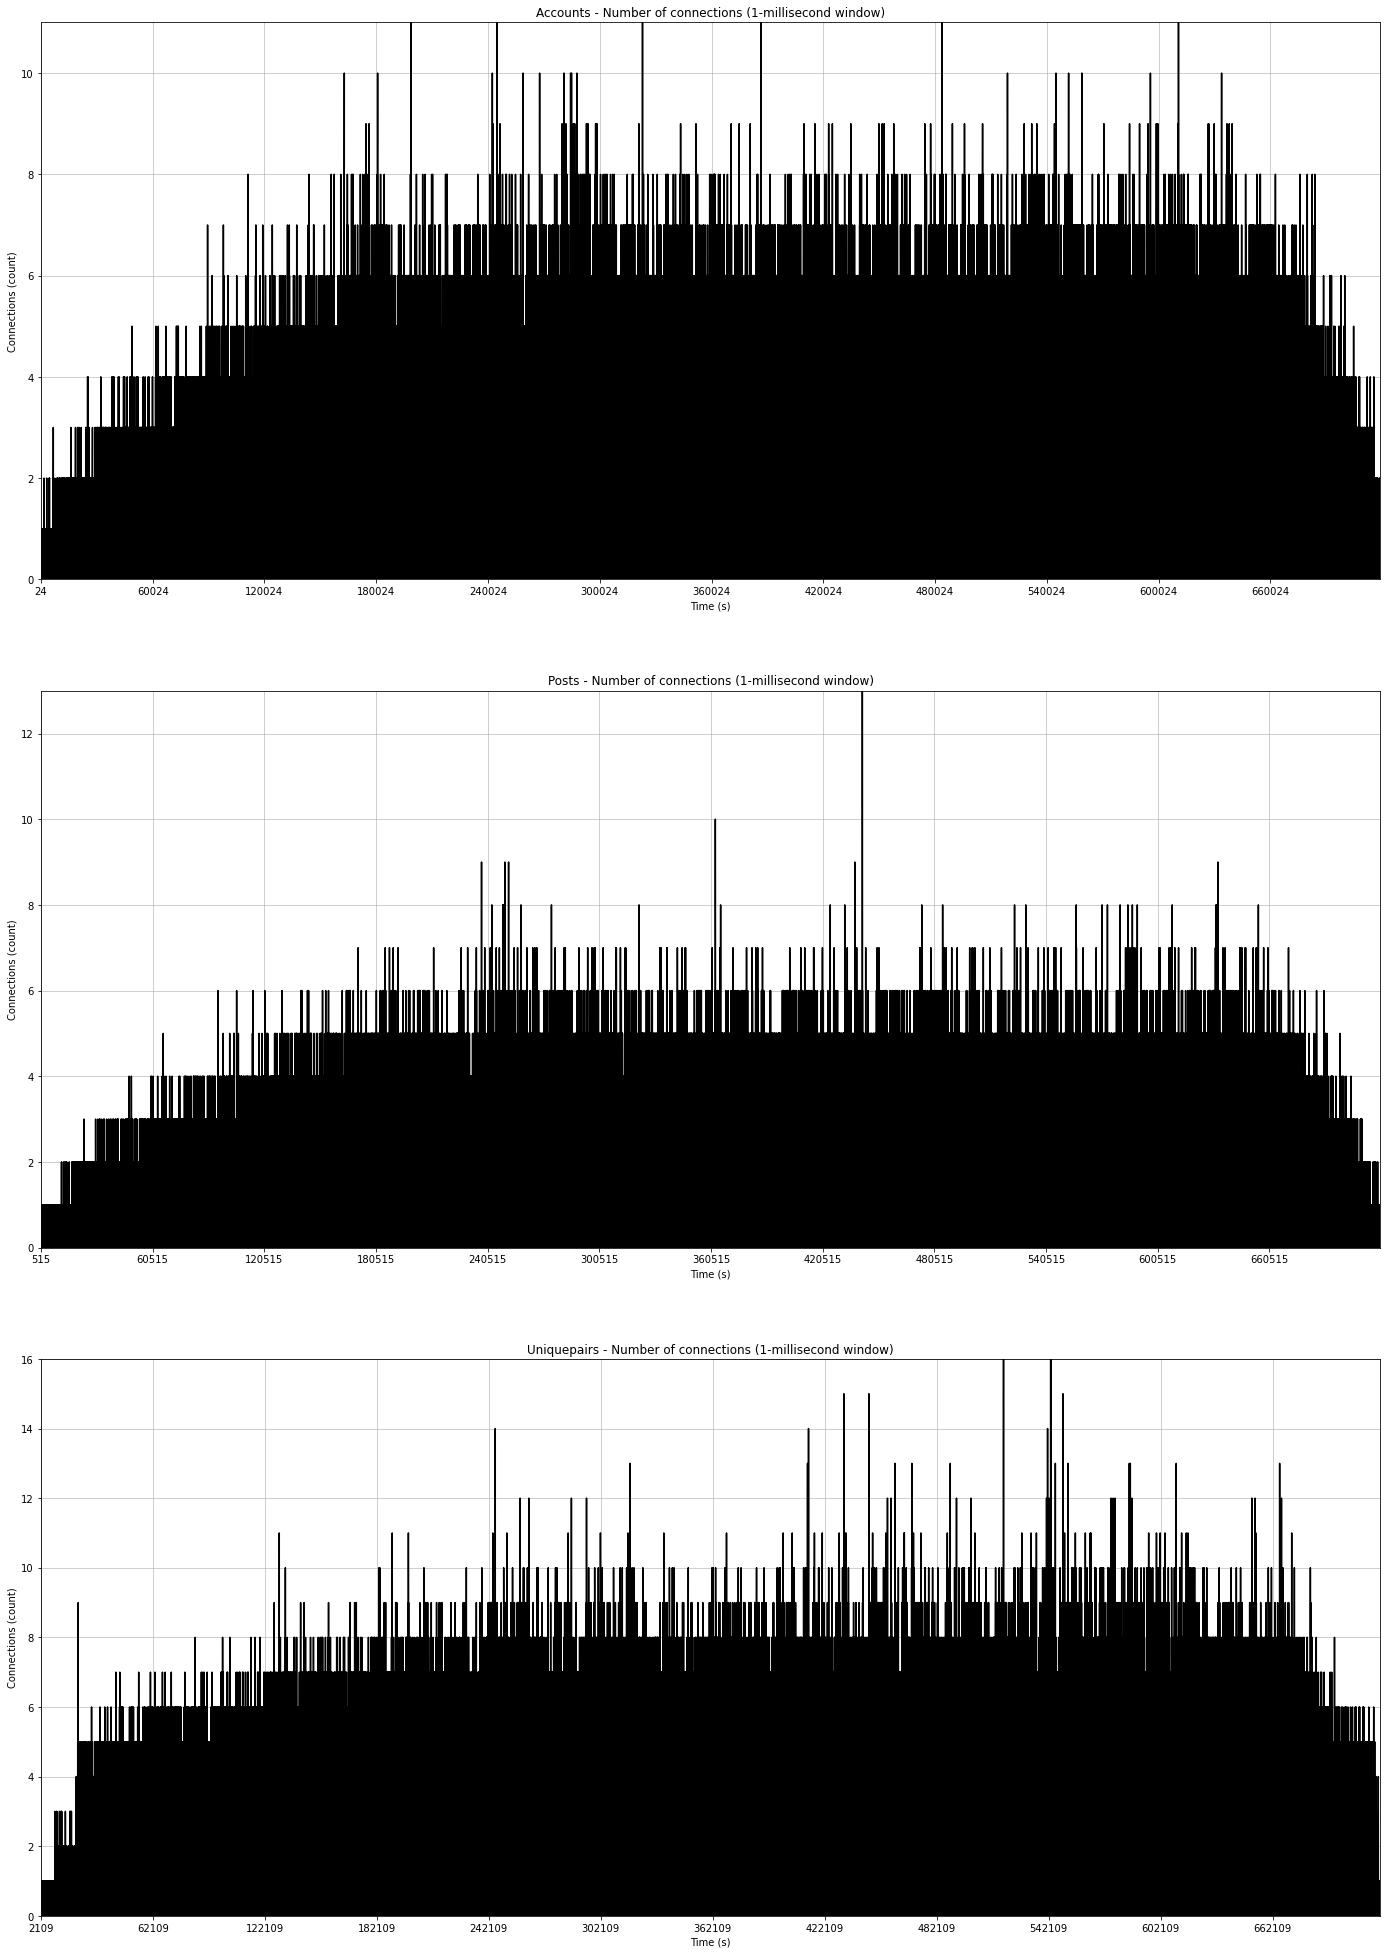

In [14]:
########## LOCAL CONFIG
# Minimum time (in seconds)
MIN_TIME = None
# Maximum time (in seconds)
MAX_TIME = None

# Plot number of connections
fig = plt.figure(figsize=(24, len(servers) * 12))
for (i, dbname) in enumerate(dbnames):
    df = query[(query["dbname"] == dbname)]
    if MIN_TIME:
        df = df[(df["timestamp"] >= MIN_TIME)]
    if MAX_TIME:
        df = df[(df["timestamp"] <= MAX_TIME)]
    df = df.groupby(["window"])["window"].count()
    df = df.reindex(range(int(df.index.min()), int(df.index.max()) + 1), fill_value=0)
    ax = fig.add_subplot(len(servers), 1, i + 1)
    ax.grid(alpha=0.75)
    ax.set_xlim((df.index.min(), df.index.max()))
    ax.set_ylim((0, df.values.max()))
    ax.axhline(y=PG_MAX_CONNECTIONS, ls="--", color="blue", linewidth=5)
    ax.axhline(y=PG_MAX_CONNECTIONS + PG_SOMAXCONN, ls="--", color="red", linewidth=5)
    df.plot(ax=ax, kind="line",
        title="%s - Number of connections (%s-millisecond window)" % (dbname, WINDOW_IN_MS),
        xlabel="Time (s)", ylabel="Connections (count)", color="black", grid=True,
        xticks=range(int(df.index.min()), int(df.index.max()) + 1, 60 * (1000 // WINDOW_IN_MS)))

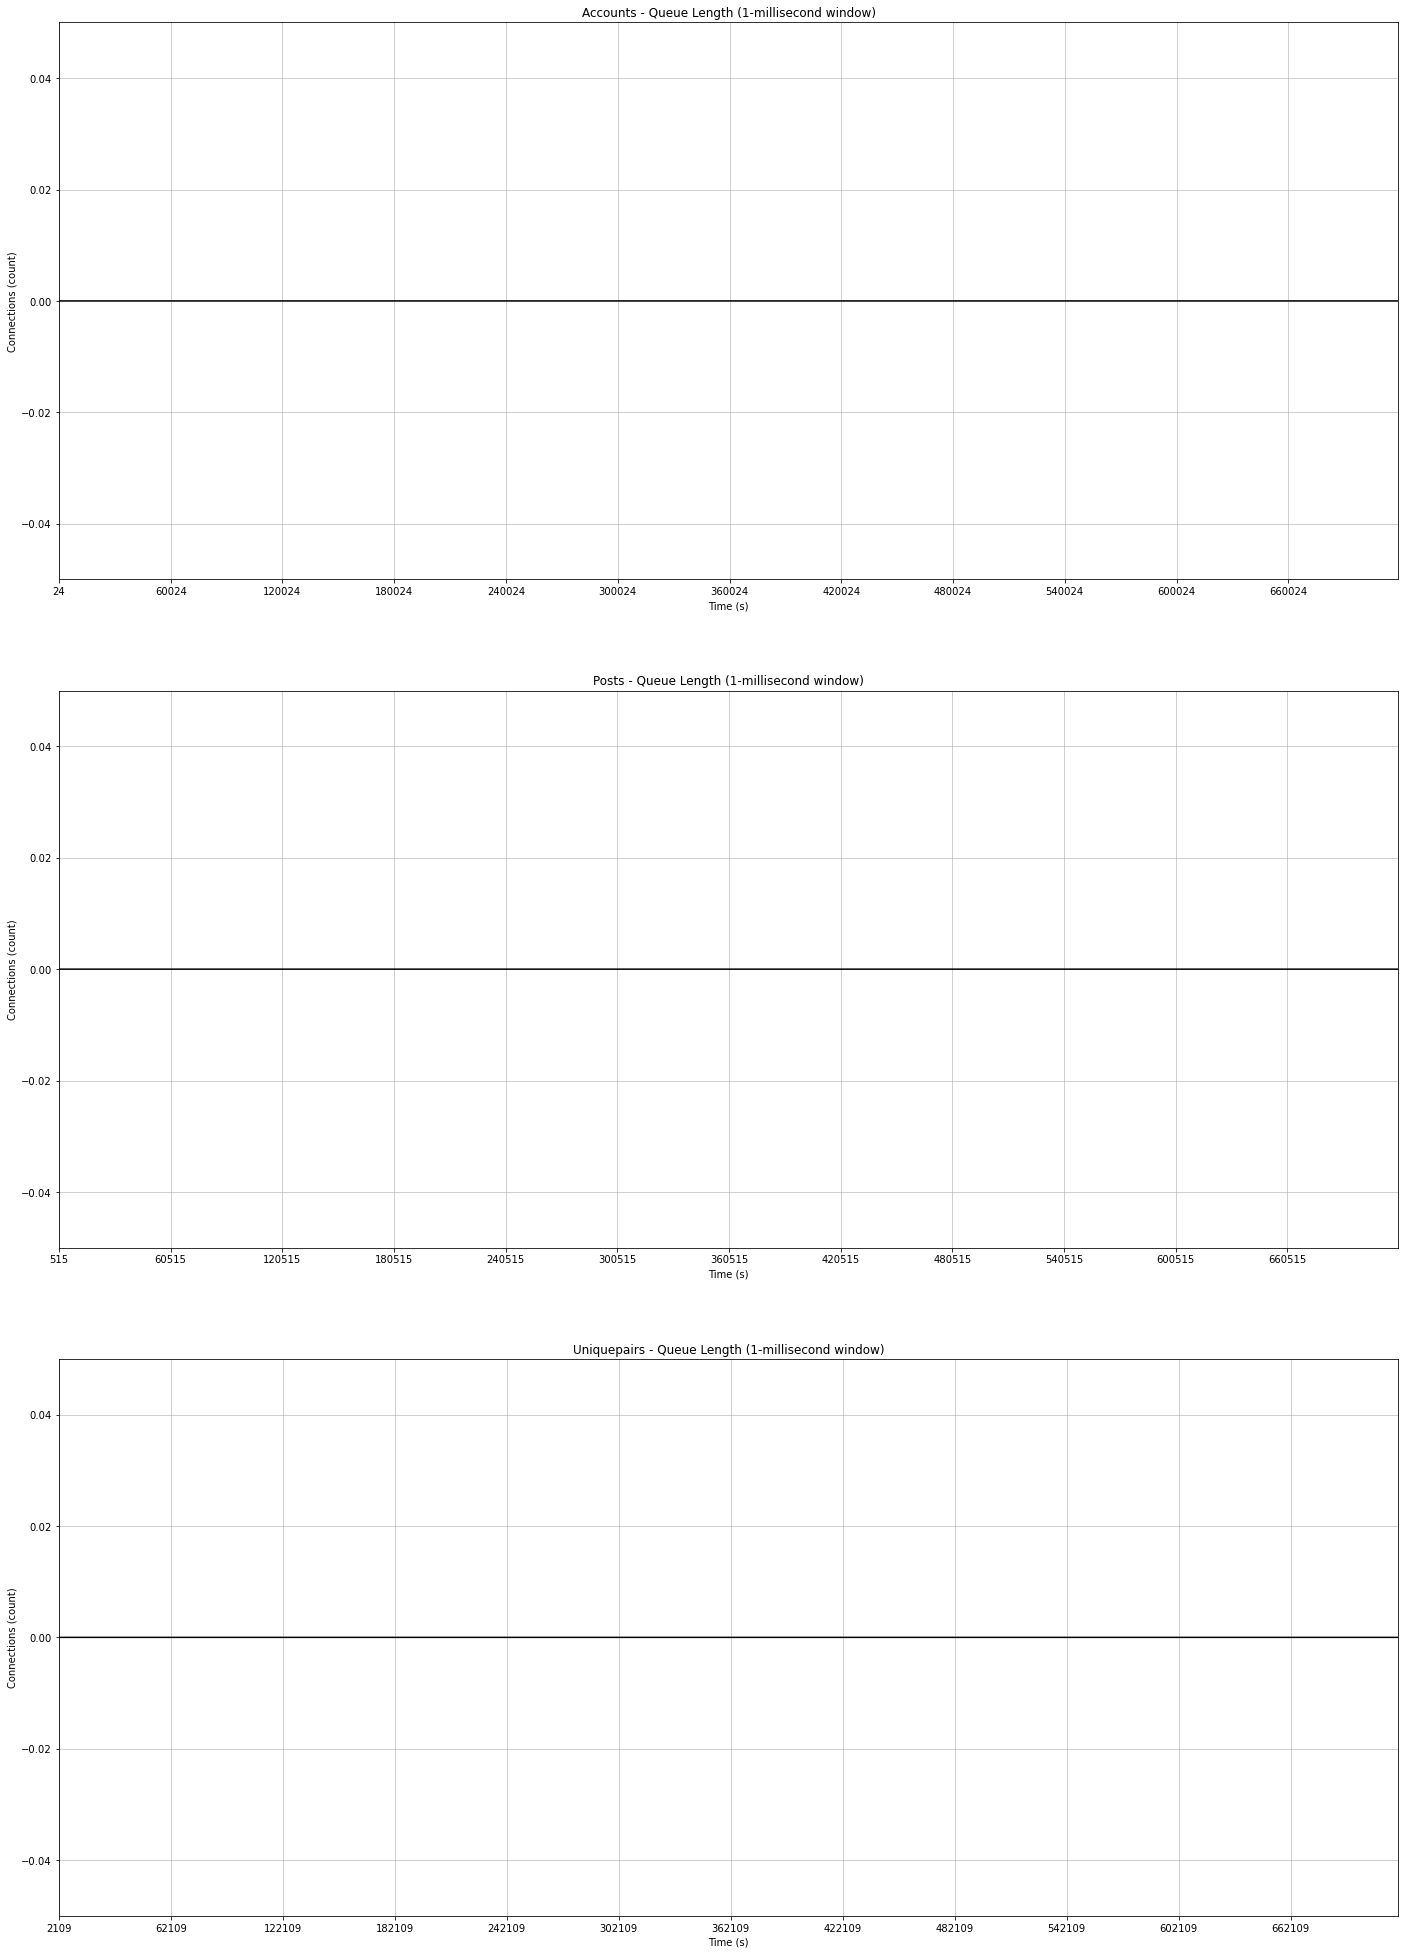

In [15]:
########## LOCAL CONFIG
# Minimum time (in seconds)
MIN_TIME = None
# Maximum time (in seconds)
MAX_TIME = None

# Plot queue length
fig = plt.figure(figsize=(24, len(servers) * 12))
for (i, dbname) in enumerate(dbnames):
    df = query[(query["dbname"] == dbname)]
    if MIN_TIME:
        df = df[(df["timestamp"] >= MIN_TIME)]
    if MAX_TIME:
        df = df[(df["timestamp"] <= MAX_TIME)]
    df = df.groupby(["window"])["window"].count()
    df = df.apply(lambda r: max(r - PG_MAX_CONNECTIONS, 0))
    df = df.reindex(range(int(df.index.min()), int(df.index.max()) + 1), fill_value=0)
    ax = fig.add_subplot(len(servers), 1, i + 1)
    ax.grid(alpha=0.75)
    ax.set_xlim((df.index.min(), df.index.max()))
    ax.set_ylim((0, df.values.max()))
    ax.axhline(y=PG_SOMAXCONN, ls="--", color="red", linewidth=5)
    df.plot(ax=ax, kind="line",
        title="%s - Queue Length (%s-millisecond window)" % (dbname, WINDOW_IN_MS),
        xlabel="Time (s)", ylabel="Connections (count)", color="black", grid=True,
        xticks=range(int(df.index.min()), int(df.index.max()) + 1, 60 * (1000 // WINDOW_IN_MS)))